In [1]:
%load_ext autoreload

# Studies for SMEFT@NLO discussion in 2022

3 samples, top-W scattering @NLO, ttW_QCD @NLO, ttW_QCD+QED @LO.

All samples are in
/ceph/cms/store/user/dspitzba/ProjectMetis/

TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/

TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/


ttlnuJet_all22WCs_RunIISummer20_NanoGEN_NANO_v26/merged/

TTWToLNu_SM_RunIISummer20_NanoGEN_NANO_v26//merged/


Also use hist instead of coffea hist / yahist / boost histogram --> for future migrations

First, make histograms of the weight distributions of my signal samples. Very basic sanity check.

In [532]:
import awkward as ak
import hist
import glob
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
NanoAODSchema.warn_missing_crossrefs = False

base_dir = '/ceph/cms/store/user/dspitzba/ProjectMetis/'

In [533]:
!ls /ceph/cms/store/user/dspitzba/ProjectMetis//TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/

merged_0.root	merged_13.root	merged_1.root  merged_5.root  merged_9.root
merged_10.root	merged_14.root	merged_2.root  merged_6.root
merged_11.root	merged_15.root	merged_3.root  merged_7.root
merged_12.root	merged_16.root	merged_4.root  merged_8.root


In [534]:
f_in = f'{base_dir}/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/merged_0.root'
#f_in = f'{base_dir}/TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/merged_0.root'
topW_TtoLep = NanoEventsFactory.from_root(
    f_in,
    #'/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_60.root',
    schemaclass=NanoAODSchema,
).events()

In [535]:
w = topW_TtoLep.LHEWeight
weights = ak.Array([
    w.cpt_0p_cpqm_0p_nlo,
    w.cpt_3p_cpqm_0p_nlo,
    w.cpt_6p_cpqm_0p_nlo,
    w.cpt_0p_cpqm_3p_nlo,
    w.cpt_0p_cpqm_6p_nlo,
    w.cpt_3p_cpqm_3p_nlo,
])

In [536]:
bad_events = ak.all(weights == 1, axis=0)
bad_events

<Array [False, False, False, ... False, False] type='70000 * bool'>

In [537]:
topW_TtoLep = topW_TtoLep[~bad_events]

In [538]:
topW_TtoLep.LHEWeight.fields

['originalXWGTUP',
 'cpt_0p_cpqm_0p_nlo',
 'cpt_3p_cpqm_0p_nlo',
 'cpt_6p_cpqm_0p_nlo',
 'cpt_0p_cpqm_3p_nlo',
 'cpt_0p_cpqm_6p_nlo',
 'cpt_3p_cpqm_3p_nlo']

In [539]:
weight_axis = hist.axis.Regular(50, -1, 20, name="weight_ax", label="weight", underflow=True, overflow=True)

h_0 = hist.Hist(weight_axis)
h_0.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_0p_cpqm_0p_nlo)

h_1 = hist.Hist(weight_axis)
h_1.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_6p_cpqm_0p_nlo)

h_2 = hist.Hist(weight_axis)
h_2.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_0p_cpqm_6p_nlo)

h_3 = hist.Hist(weight_axis)
h_3.fill(weight_ax=topW_TtoLep.LHEWeight.cpt_3p_cpqm_3p_nlo)

Hist(Regular(50, -1, 20, name='weight_ax', label='weight'), storage=Double()) # Sum: 64952.0 (65000.0 with flow)

In [540]:
# number of events with weight > 20 ("problematic")
h_1.values(flow=True)[-1]/sum(h_1.values(flow=True))

0.0026153846153846153

In [541]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

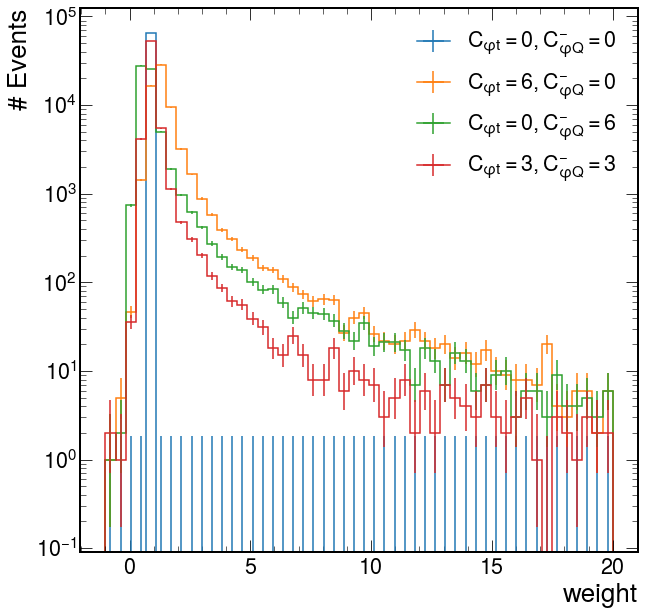

In [542]:
f, ax = plt.subplots()

h_0.plot1d(ax=ax, label=r'$C_{\varphi t}=0, C_{\varphi Q}^{-}=0$')
h_1.plot1d(ax=ax, label=r'$C_{\varphi t}=6, C_{\varphi Q}^{-}=0$')
h_2.plot1d(ax=ax, label=r'$C_{\varphi t}=0, C_{\varphi Q}^{-}=6$')
h_3.plot1d(ax=ax, label=r'$C_{\varphi t}=3, C_{\varphi Q}^{-}=3$')

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'weight')

ax.set_yscale("log")

plt.legend()


In [543]:
ak.mean(topW_TtoLep.LHEWeight.cpt_0p_cpqm_0p_nlo)

0.9999980168269231

In [544]:
len(topW_TtoLep)

65000

## Get the Polynom for the simple case - 2 Wilson coefficients, 6 weights

In [545]:
from Tools.reweighting import get_coordinates, get_coordinates_and_ref
coords, ref_coords = get_coordinates_and_ref(f_in, is2D=True)

In [546]:
from Tools.HyperPoly import HyperPoly  # maybe need awkward hyperpoly

In [547]:
topW_TtoLep.LHEWeight.fields

['originalXWGTUP',
 'cpt_0p_cpqm_0p_nlo',
 'cpt_3p_cpqm_0p_nlo',
 'cpt_6p_cpqm_0p_nlo',
 'cpt_0p_cpqm_3p_nlo',
 'cpt_0p_cpqm_6p_nlo',
 'cpt_3p_cpqm_3p_nlo']

In [548]:
w = topW_TtoLep.LHEWeight
weights = ak.Array([
    w.cpt_0p_cpqm_0p_nlo,
    w.cpt_3p_cpqm_0p_nlo,
    w.cpt_6p_cpqm_0p_nlo,
    w.cpt_0p_cpqm_3p_nlo,
    w.cpt_0p_cpqm_6p_nlo,
    w.cpt_3p_cpqm_3p_nlo,
])

In [549]:
hp = HyperPoly(2)
hp.initialize( coords, ref_coords )
coeff = hp.get_parametrization(weights)

In [550]:
sum_SM = sum(hp.eval(coeff, [0,0])*topW_TtoLep.genWeight)
sum_SM

226.05430372484958

In [551]:
topW_TtoLep.genWeight

<Array [0.00371, 0.00371, ... 0.00371, 0.00371] type='65000 * float32[parameters...'>

In [552]:
topW_TtoLep_scan_cpt = []
topW_TtoLep_scan_cpqm = []
for i in range(-20,21):
    topW_TtoLep_scan_cpt.append(sum(hp.eval(coeff, [i,0])*topW_TtoLep.genWeight)/sum_SM)
    topW_TtoLep_scan_cpqm.append(sum(hp.eval(coeff, [0,i])*topW_TtoLep.genWeight)/sum_SM)

In [553]:
topW_TtoLep_scan_cpt

[5.926656526410171,
 5.409495008157708,
 4.920841773266957,
 4.460696821736352,
 4.029060153567707,
 3.6259317687610424,
 3.251311667313983,
 2.90519984922901,
 2.5875963145055887,
 2.2985010631429956,
 2.037914095141855,
 1.8058354105019923,
 1.6022650092233761,
 1.4272028913060415,
 1.2806490567499647,
 1.1626035055551496,
 1.073066237721598,
 1.012037253249301,
 0.9795165521382825,
 0.9755041343885181,
 1.0,
 1.0530041489727617,
 1.134516581306777,
 1.2445372970020612,
 1.3830662960586069,
 1.550103578476408,
 1.7456491442554825,
 1.9697029933958126,
 2.2222651258974135,
 2.5033355417601593,
 2.8129142409844037,
 3.151001223569791,
 3.517596489516444,
 3.9127000388244166,
 4.336311871493521,
 4.7884319875242065,
 5.269060386915626,
 5.778197069668678,
 6.315842035783725,
 6.881995285258494,
 7.476656818095439]

In [554]:
hp.root_func_string(coeff[1])

'0.100606+0.224482*x0+0.071274*x1-0.015849*x0**2-0.018799*x0*x1+0.049077*x1**2'

In [555]:
coeff[0]

array([1.        , 0.99996948, 0.99996948, ..., 1.        , 1.        ,
       1.        ])

In [556]:
coeff_axis = hist.axis.Regular(50, -2, 2, name="coeff", label="coeff", underflow=True, overflow=True)

ch_0 = hist.Hist(coeff_axis)
ch_0.fill(coeff=coeff[0])

ch_1 = hist.Hist(coeff_axis)
ch_1.fill(coeff=coeff[1])

ch_2 = hist.Hist(coeff_axis)
ch_2.fill(coeff=coeff[2])

ch_3 = hist.Hist(coeff_axis)
ch_3.fill(coeff=coeff[3])

ch_4 = hist.Hist(coeff_axis)
ch_4.fill(coeff=coeff[4])

ch_5 = hist.Hist(coeff_axis)
ch_5.fill(coeff=coeff[5])

Hist(Regular(50, -2, 2, name='coeff', label='coeff'), storage=Double()) # Sum: 64971.0 (65000.0 with flow)

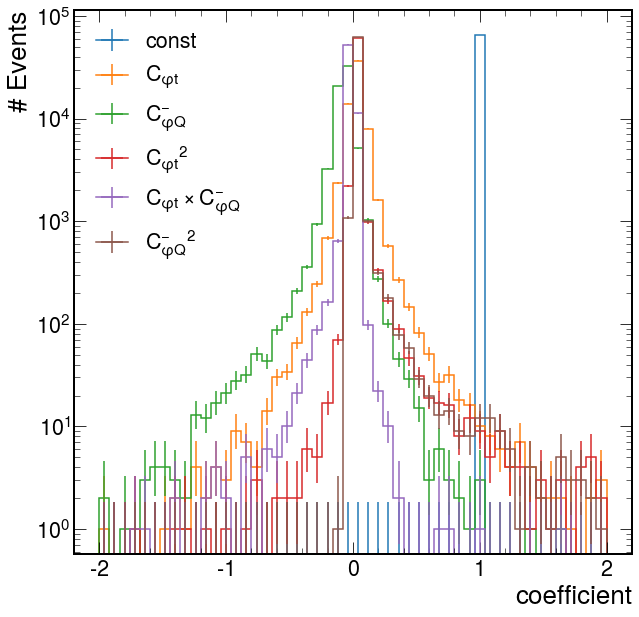

In [557]:
f, ax = plt.subplots()

ch_0.plot1d(ax=ax, label=r'const')
ch_1.plot1d(ax=ax, label=r'$C_{\varphi t}$')
ch_2.plot1d(ax=ax, label=r'$C_{\varphi Q}^{-}$')
ch_3.plot1d(ax=ax, label=r'${C_{\varphi t}}^{2}$')
ch_4.plot1d(ax=ax, label=r'$C_{\varphi t} \times C_{\varphi Q}^{-}$')
ch_5.plot1d(ax=ax, label=r'${C_{\varphi Q}^{-}}^{2}$')


ax.set_ylabel(r'# Events')
ax.set_xlabel(r'coefficient')

ax.set_yscale("log")

plt.legend()

In [558]:
topW_TtoLep.GenDressedLepton.pdgId

<Array [[11], [-13, -11], ... -13], [-11, 13]] type='65000 * var * int32[paramet...'>

In [561]:
f_in = f'{base_dir}/TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/merged_0.root'
TTWToLNu_TtoAll = NanoEventsFactory.from_root(
    f_in,
    #'/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_60.root',
    schemaclass=NanoAODSchema,
).events()

w = TTWToLNu_TtoAll.LHEWeight
weights = ak.Array([
    w.cpt_0p_cpqm_0p_nlo,
    w.cpt_3p_cpqm_0p_nlo,
    w.cpt_6p_cpqm_0p_nlo,
    w.cpt_0p_cpqm_3p_nlo,
    w.cpt_0p_cpqm_6p_nlo,
    w.cpt_3p_cpqm_3p_nlo,
])

bad_events = ak.all(weights == 1, axis=0)

TTWToLNu_TtoAll = TTWToLNu_TtoAll[~bad_events]

w = TTWToLNu_TtoAll.LHEWeight
weights = ak.Array([
    w.cpt_0p_cpqm_0p_nlo,
    w.cpt_3p_cpqm_0p_nlo,
    w.cpt_6p_cpqm_0p_nlo,
    w.cpt_0p_cpqm_3p_nlo,
    w.cpt_0p_cpqm_6p_nlo,
    w.cpt_3p_cpqm_3p_nlo,
])

hp = HyperPoly(2)
hp.initialize( coords, ref_coords )
coeff = hp.get_parametrization(weights)

sum_SM = sum(hp.eval(coeff, [0,0])*TTWToLNu_TtoAll.genWeight)

TTWToLNu_TtoAll_scan_cpt = []
TTWToLNu_TtoAll_scan_cpqm = []
for i in range(-20,21):
    TTWToLNu_TtoAll_scan_cpt.append(sum(hp.eval(coeff, [i,0])*TTWToLNu_TtoAll.genWeight)/sum_SM)
    TTWToLNu_TtoAll_scan_cpqm.append(sum(hp.eval(coeff, [0,i])*TTWToLNu_TtoAll.genWeight)/sum_SM)

    
def get_ratio(coeff, events, cpt, cpqm):
    return sum(hp.eval(coeff, [cpt,cpqm])*events.genWeight)/sum(events.genWeight)

In [570]:
xsecs = {
    "TTWToLNu_TtoLep_aTtoHad": 3.420e-3,
    "TTWToLNu_TtoAll_aTtoLep": 5.060e-3,
    "TTWToLNu_SM": 0.2043,
}

# need to correct SM ttW_QCD x-sec for leptonic top BR assumed in other exclusive samples
# 0.108*3 * (1-0.108*3) + 3*0.108 = 0.543

nlo_scaling_cpt = (xsecs["TTWToLNu_TtoAll_aTtoLep"] * np.array(TTWToLNu_TtoAll_scan_cpt) +\
  xsecs["TTWToLNu_TtoLep_aTtoHad"] * np.array(topW_TtoLep_scan_cpt) +\
  xsecs["TTWToLNu_SM"]*0.543)/(xsecs["TTWToLNu_TtoAll_aTtoLep"]+\
                         xsecs["TTWToLNu_TtoLep_aTtoHad"]+\
                         xsecs["TTWToLNu_SM"]*0.543)

nlo_scaling_cpt

array([1.35739111, 1.31992292, 1.28451775, 1.25117559, 1.21989645,
       1.19068032, 1.1635272 , 1.13843709, 1.11541   , 1.09444593,
       1.07554487, 1.05870682, 1.04393178, 1.03121976, 1.02057075,
       1.01198476, 1.00546178, 1.00100182, 0.99860486, 0.99827092,
       1.        , 1.00379209, 1.00964719, 1.01756531, 1.02754644,
       1.03959058, 1.05369774, 1.06986791, 1.0881011 , 1.1083973 ,
       1.13075651, 1.15517874, 1.18166398, 1.21021223, 1.2408235 ,
       1.27349778, 1.30823508, 1.34503539, 1.38389871, 1.42482505,
       1.4678144 ])

In [563]:
(xsecs["TTWToLNu_TtoLep_aTtoHad"]+xsecs["TTWToLNu_TtoAll_aTtoLep"])/xsecs["TTWToLNu_SM"]

0.04150758688203622

In [571]:
nlo_scaling_cpqm = (xsecs["TTWToLNu_TtoAll_aTtoLep"] * np.array(TTWToLNu_TtoAll_scan_cpqm) +\
  xsecs["TTWToLNu_TtoLep_aTtoHad"] * np.array(topW_TtoLep_scan_cpqm) +\
  xsecs["TTWToLNu_SM"]*0.543)/(xsecs["TTWToLNu_TtoAll_aTtoLep"]+\
                         xsecs["TTWToLNu_TtoLep_aTtoHad"]+\
                         xsecs["TTWToLNu_SM"]*0.543)

nlo_scaling_cpqm

array([1.55536822, 1.50634732, 1.45956352, 1.41501682, 1.37270723,
       1.33263475, 1.29479937, 1.25920109, 1.22583992, 1.19471585,
       1.16582889, 1.13917903, 1.11476627, 1.09259062, 1.07265208,
       1.05495064, 1.0394863 , 1.02625907, 1.01526894, 1.00651592,
       1.        , 0.99572119, 0.99367948, 0.99387487, 0.99630737,
       1.00097698, 1.00788368, 1.0170275 , 1.02840841, 1.04202644,
       1.05788156, 1.07597379, 1.09630313, 1.11886957, 1.14367311,
       1.17071376, 1.19999152, 1.23150637, 1.26525834, 1.3012474 ,
       1.33947357])

In [565]:
kelci = {
    "sm*sm": 1.0,

    "cpt*sm": 0.0022769891823095838,
    "cpQM*sm": -0.005396180611031845,

    "cpQM*cpt": -0.000531132938238176,

    "cpt*cpt": 0.0009878525312644198,
    "cpQM*cpQM": 0.0010378318195987384,
}

In [566]:
def ttW_ML(cpt, cpqm):
    return 1 + cpt*kelci["cpt*sm"] + cpqm*kelci["cpQM*sm"] + cpt*cpqm*kelci["cpQM*cpt"] + cpt**2 * kelci["cpt*cpt"] + cpqm**2 * kelci["cpQM*cpQM"]

In [577]:
ttW_ML(10,10)

1.1182632269752757

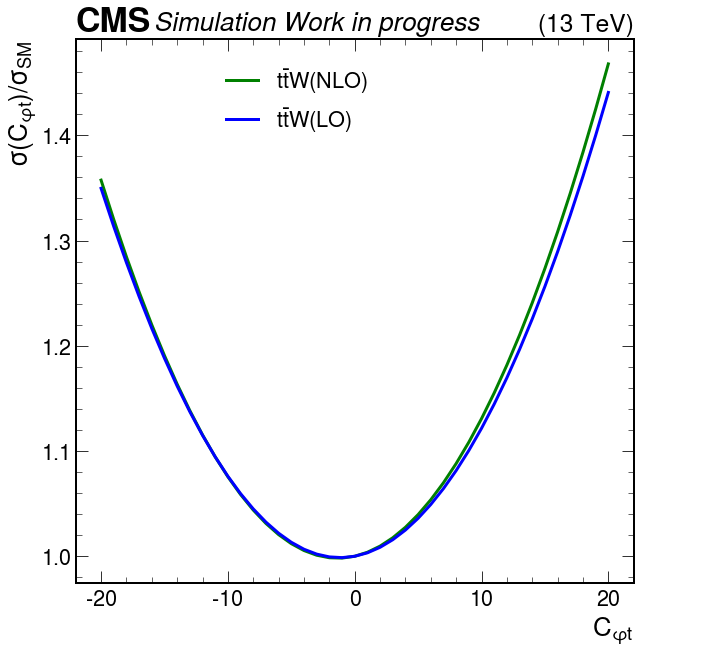

In [576]:
fig, ax = plt.subplots()
hep.cms.label(
    "Work in progress",
    data=False,
    lumi=None,
    loc=0,
    ax=ax,
)

cpt = np.arange(-20,21,1)

plt.plot(cpt, nlo_scaling_cpt, label=r'$t\bar{t}W (NLO)$', c='green', linewidth=3)
plt.plot(cpt, [ttW_ML(c, 0) for c in cpt], label=r'$t\bar{t}W (LO)$', c='blue', linewidth=3)

ax.set_xlabel(r'$C_{\varphi t}$')
ax.set_ylabel(r'$\sigma(C_{\varphi t})/\sigma_{SM}$')

plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.23, 0.88, 0.90, .11),
        mode="expand",
)

plt.show()

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/SMEFTatNLO/cpt_comparison.pdf')

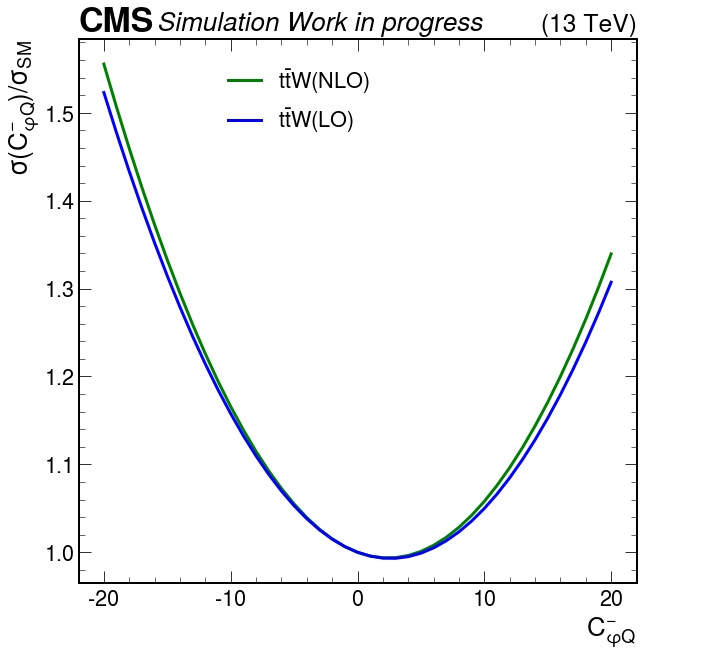

In [575]:
fig, ax = plt.subplots()
hep.cms.label(
    "Work in progress",
    data=False,
    lumi=None,
    loc=0,
    ax=ax,
)

cpt = np.arange(-20,21,1)

plt.plot(cpt, nlo_scaling_cpqm, label=r'$t\bar{t}W (NLO)$', c='green', linewidth=3)
plt.plot(cpt, [ttW_ML(0, c) for c in cpt], label=r'$t\bar{t}W (LO)$', c='blue', linewidth=3)

ax.set_xlabel(r'$C_{\varphi Q}^{-}$')
ax.set_ylabel(r'$\sigma(C_{\varphi Q}^{-})/\sigma_{SM}$')

plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.23, 0.88, 0.90, .11),
        mode="expand",
)

plt.show()

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/SMEFTatNLO/cpqm_comparison.pdf')

## Multidimensional LO ttW sample

In [483]:
import numpy as np
import itertools

from Tools.reweighting import eft_point, eft_setup

In [484]:
f_in = f'{base_dir}/ttlnuJet_all22WCs_RunIISummer20_NanoGEN_NANO_v26/merged/merged_0.root'
events = NanoEventsFactory.from_root(
    f_in,
    #'/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_60.root',
    schemaclass=NanoAODSchema,
).events()

In [485]:
test = eft_setup('../production/cards/ttlnuJet_all22WCs/ttlnuJet_all22WCsStartPtCheckdim6TopMay20GST_run0_customizecards.dat', events)

In [486]:
weight_names = events.LHEWeight.fields#[:276]
weights = [getattr(events.LHEWeight, w) for w in weight_names[2:]]
w = np.array(weights)

In [487]:
len(w[0,:])

65699

In [488]:
combination  = {}
counter = 0
order = 2
nvar = 22
for o in range(order+1):
    for comb in itertools.combinations_with_replacement( range(nvar), o ):
        combination[counter] = comb
        counter += 1

m = 332
n = int((nvar+1)*(nvar+2)/2)
A = np.empty( [m, n ] )
param_points = test.get_coordinates()
ref_point = test.get_ref_point()
combinations = list(combination.values())
for d in range(m):
    for e in range(n):
        A[d][e] = np.prod([param_points[d][x]-ref_point[x] for x in combinations[e]])

In [489]:
res = np.linalg.lstsq(A, w, rcond=None)

In [490]:
new_point = [0]*n
sm_vec = [ np.prod([new_point[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]
sm_weight = np.dot(res[0].T, sm_vec)
sum(sm_weight)

20701.341098513494

In [516]:
test_point = eft_point.from_customize_card('../production/cards/ttlnuJet_all22WCs/ttlnuJet_all22WCsStartPtCheckdim6TopMay20GST_run0_customizecards.dat')
test_point.set({"cpt":10.0, "cpQM":10.0}, reset=True)
test_point.show()
bsm_vec = [ np.prod([test_point.get_coord()[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]
bsm_weight = np.dot(res[0].T, bsm_vec)
sum(bsm_weight)/sum(sm_weight)

   ctlTi  ctq1  ctq8  cQlMi  cQq81  cQq83  cbW  cpQ3  ctei  ctlSi  ...  cQei  \
0      0     0     0      0      0      0    0     0     0      0  ...     0   

   ctZ  cQl3i  ctG  cQq13  cQq11  cptb  ctli  ctp   cpt  
0    0      0    0      0      0     0     0    0  10.0  

[1 rows x 22 columns]


1.1220507302362244

In [31]:
'''
test_scan = []

for i in range(-20,21):
    test_point.set({"cpt":i, "cpQM":0.0, "ctZ":0}, reset=True)
    bsm_vec = [ np.prod([test_point.get_coord()[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]
    bsm_weight = np.dot(res[0].T, bsm_vec)
    print (i, sum(bsm_weight)/sum(sm_weight))
    test_scan.append(sum(bsm_weight)/sum(sm_weight))
'''

'\ntest_scan = []\n\nfor i in range(-20,21):\n    test_point.set({"cpt":i, "cpQM":0.0, "ctZ":0}, reset=True)\n    bsm_vec = [ np.prod([test_point.get_coord()[x]-ref_point[x] for x in combinations[e]]) for e in range(n) ]\n    bsm_weight = np.dot(res[0].T, bsm_vec)\n    print (i, sum(bsm_weight)/sum(sm_weight))\n    test_scan.append(sum(bsm_weight)/sum(sm_weight))\n'

In [32]:
np.dot(res[0].T, sm_vec)

array([3.65372246e-03, 1.00553804e-06, 8.08841467e-01, ...,
       5.71731841e-05, 2.28950603e-01, 5.41300824e-02])

In [33]:
print (weight_names[-1])
getattr(events.LHEWeight, weight_names[-1])[0]

EFTrwgt331_ctlTi_0.0_ctq1_0.0_ctq8_0.0_cQq83_0.0_cQq81_0.0_cQlMi_0.0_cbW_0.0_cpQ3_0.0_ctei_0.0_cQei_0.0_ctW_0.0_cpQM_0.0_ctlSi_0.0_ctZ_0.0_cQl3i_0.0_ctG_0.0_cQq13_0.0_cQq11_0.0_cptb_0.0_ctli_0.0_ctp_0.0_cpt_0.0


0.003650188446044922

In [34]:
len(events)

65699

In [35]:
np.dot(res[0].T, sm_vec)

array([3.65372246e-03, 1.00553804e-06, 8.08841467e-01, ...,
       5.71731841e-05, 2.28950603e-01, 5.41300824e-02])

In [36]:
getattr(events.LHEWeight, weight_names[-1])

<Array [0.00365, 0, 0.809, ... 0.229, 0.0541] type='65699 * float32[parameters={...'>

In [242]:
class EFT_analysis(processor.ProcessorABC):
    def __init__(self):
        lt_axis = hist.axis.Regular(20, 0, 1000, name="lt", label="$L_{T}$ (GeV)")

        self.make_output = lambda: {
            'lt_sm': hist.Hist(lt_axis, storage=hist.storage.Weight()),
            'lt': hist.Hist(lt_axis, storage=hist.storage.Weight()),
            "EventCount": processor.value_accumulator(int),
            "sumw": processor.value_accumulator(float),
        }
        
        ######

    def process(self, events):
        output = self.make_output()

        dataset = events.metadata['dataset']
        
        isEFT = False
        is2D = False
        if hasattr(events.LHEWeight, 'cpt_0p_cpqm_0p_nlo'):
            isEFT = True
            is2D = True
        elif hasattr(events.LHEWeight, weight_names[-1]):
            isEFT = True
            is2D = False
        
        if isEFT and is2D:
            w = events.LHEWeight
            weights = ak.Array([
                w.cpt_0p_cpqm_0p_nlo,
                w.cpt_3p_cpqm_0p_nlo,
                w.cpt_6p_cpqm_0p_nlo,
                w.cpt_0p_cpqm_3p_nlo,
                w.cpt_0p_cpqm_6p_nlo,
                w.cpt_3p_cpqm_3p_nlo,
            ])
            
            bad_events = ak.all(weights == 1, axis=0)
            events = events[~bad_events]
            
            # I'm lazy. there has to be a better way
            
            w = events.LHEWeight
            weights = ak.Array([
                w.cpt_0p_cpqm_0p_nlo,
                w.cpt_3p_cpqm_0p_nlo,
                w.cpt_6p_cpqm_0p_nlo,
                w.cpt_0p_cpqm_3p_nlo,
                w.cpt_0p_cpqm_6p_nlo,
                w.cpt_3p_cpqm_3p_nlo,
            ])
                        
            sm_weight = np.ones(len(events))

            coeff = hp.get_parametrization(weights)
            bsm_weight = hp.eval(coeff, [10, 10])
            
        elif isEFT and not is2D:
            w = [getattr(events.LHEWeight, w) for w in weight_names[2:]]  # cut away garbage weights
            res = np.linalg.lstsq(A, w, rcond=None)  # solve the linear equation system
            
            sm_weight = np.dot(res[0].T, sm_vec)
            bsm_weight = np.dot(res[0].T, bsm_vec)
            
        else:
            sm_weight = np.ones(len(events))
        
        output["EventCount"] = len(events) 
        output["sumw"] = ak.sum(events.genWeight)
        
        met = events.GenMET
        lepton = events.GenDressedLepton
        jet = events.GenJet
        
        sel_jet = jet[((jet.pt>25)&(abs(jet.eta)<2.4))]
        
        lt = met.pt + ak.sum(lepton.pt[:,:2], axis=1)
        
        ######
        
        event_sel = ((ak.num(lepton)==2) & (abs(ak.sum(lepton.pdgId, axis=1))>0) & (ak.num(sel_jet)>3))
        
        if isEFT:
            output['lt'].fill(
                lt=lt[event_sel],
                weight=(events.genWeight*bsm_weight)[event_sel],  # NOTE: signs of weights checked.
            )

        output['lt_sm'].fill(
            lt=lt[event_sel],
            weight=(events.genWeight*sm_weight)[event_sel],
        )
                
        return {dataset: output}

    def postprocess(self, accumulator):
        return accumulator

In [243]:
# ipython -i samples.py -- --load --input data/samples.yaml
# samples.db['/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM'].get_absolute_files()

files_central_TTW = [
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/82A10998-FF53-0F47-B9DB-F2A0312B94D9.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/9D42A19B-9528-694A-80DB-EA8DE96DF2EF.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/76896107-5C5D-F745-9C32-96032A08DBD0.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/659CC9F7-462C-354C-871F-2D43ECD0D738.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/CE942A79-86EE-D14B-9C4E-8176ACA9B675.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/9BF5FF1E-2847-334B-A510-1F90EDFE3DAB.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/B458D031-E731-2B4D-B4C7-BF3CBD2FB34C.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/70000/31777CCD-9BEE-C54C-8512-9812249A0325.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/F11E5C7A-6B90-A34E-B090-156E7E1D6F89.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/FE33397E-8A80-594D-A2BF-A8CE67FEA234.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/0BF1CAC0-066F-6C41-89EF-6F7B67A8E1D7.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/77872E8A-7486-8746-9A6C-C8D05D17CC8C.root',
     'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/FAC379B0-E1DA-D647-9A57-9411A8676AD0.root',
]

In [244]:
fileset = {
    "ttlnuJet": glob.glob(f"{base_dir}/ttlnuJet_all22WCs_RunIISummer20_NanoGEN_NANO_v26/merged/*.root")[:-1],
    "TTWToLNu_TtoLep_aTtoHad": glob.glob(f"{base_dir}/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/*.root")[:-1],
    "TTWToLNu_TtoAll_aTtoLep": glob.glob(f"{base_dir}/TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/merged/*.root")[:-1],
    "TTWToLNu_SM": glob.glob(f"{base_dir}/TTWToLNu_SM_RunIISummer20_NanoGEN_NANO_v26/merged/*.root")[:-1],
#    "TTWToLNu_SM": files_central_TTW[:1],  # Something is different in the central samples wrt private NanoGEN, potentially GenMET??

}

# exe = processor.iterative_executor()
exe = processor.FuturesExecutor(workers=10)

runner = processor.Runner(
    exe,
    #retries=3,
    schema=NanoAODSchema,
    chunksize=50000,
    maxchunks=None,
)

output = runner(
    fileset,
    treename="Events",
    processor_instance=EFT_analysis(),
)


#output = processor.run_uproot_job(
#    fileset,
#    "Events",
#    EFT_analysis(),
#    processor.FuturesExecutor(workers=10),
#    {"schema": NanoAODSchema},
#    chunksize=25000,
#)

Output()

In [504]:
# SM point of LO ttlnu + jet sample MG x-sec: 0.326962929058 +- 0.0239820601814 pb (without matching)
# 
xsecs = {
    "TTWToLNu_TtoLep_aTtoHad": 3.420e-3, # 3.732e-3, # old number
    "TTWToLNu_TtoAll_aTtoLep": 5.060e-3, # 5.521e-3, # old number
    "TTWToLNu_SM": 0.2043,
    "ttlnuJet": 4.848e-01, # this number is from NanoGEN production log, 0.54639 before matching from gridpack step
}

In [246]:
output["TTWToLNu_TtoLep_aTtoHad"]["EventCount"]

928750

In [247]:
output["TTWToLNu_SM"]["EventCount"]

409575

In [248]:
output["ttlnuJet"]["lt_sm"]

Hist(Regular(20, 0, 1000, name='lt', label='$L_{T}$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=23093.1, variance=15301.1) (WeightedSum(value=23116.8, variance=15308.9) with flow)

In [249]:
output["ttlnuJet"]["lt"]

Hist(Regular(20, 0, 1000, name='lt', label='$L_{T}$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=25363.6, variance=27443.2) (WeightedSum(value=25639, variance=37456) with flow)

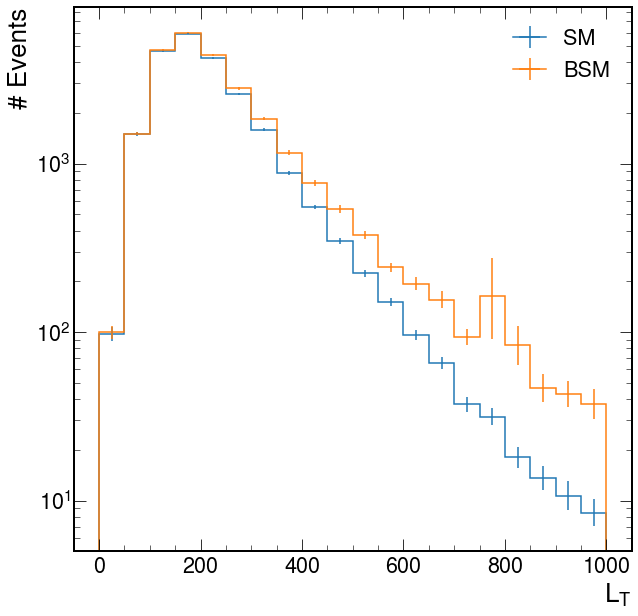

In [250]:
f, ax = plt.subplots()

output["ttlnuJet"]["lt_sm"].plot1d(ax=ax, label=r'SM')
output["ttlnuJet"]["lt"].plot1d(ax=ax, label=r'BSM')


ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T}$')

ax.set_yscale("log")

plt.legend()

### SM comparison

In [251]:
LO_h = output["ttlnuJet"]["lt_sm"].copy()
NLO_QCD_h = output["TTWToLNu_SM"]["lt_sm"].copy()
NLO_QED1_h = output["TTWToLNu_TtoLep_aTtoHad"]["lt_sm"].copy()
NLO_QED2_h = output["TTWToLNu_TtoAll_aTtoLep"]["lt_sm"].copy()

In [252]:
LO_h_scaled = LO_h*137*1000*xsecs["ttlnuJet"]/output["ttlnuJet"]["sumw"]
NLO_QCD_h_scaled = NLO_QCD_h*137*1000*xsecs["TTWToLNu_SM"]/output["TTWToLNu_SM"]["sumw"]
NLO_QED1_h_scaled = NLO_QED1_h*137*1000*xsecs["TTWToLNu_TtoLep_aTtoHad"]/output["TTWToLNu_TtoLep_aTtoHad"]["sumw"]
NLO_QED2_h_scaled = NLO_QED2_h*137*1000*xsecs["TTWToLNu_TtoAll_aTtoLep"]/output["TTWToLNu_TtoAll_aTtoLep"]["sumw"]

In [253]:
norm = (sum(NLO_QED1_h_scaled.values())+sum(NLO_QED2_h_scaled.values())+sum(NLO_QCD_h_scaled.values()))/(sum(LO_h_scaled.values()))

In [254]:
norm

1.46045164009143

In [255]:
LO_h_scaled = LO_h_scaled*norm

In [256]:
sum(NLO_QCD_h_scaled.values())

6334.532706911708

In [257]:
sum(NLO_QED1_h_scaled.values())+sum(NLO_QED2_h_scaled.values())

483.3193766962288

In [258]:
LO_h_scaled.variances(flow=True)

array([0.00000000e+00, 6.18167484e+00, 9.46173916e+01, 2.91538825e+02,
       3.59314550e+02, 2.46306169e+02, 1.42050868e+02, 8.36238712e+01,
       4.31004791e+01, 2.57161815e+01, 1.60045825e+01, 9.25252541e+00,
       6.22555621e+00, 3.71295629e+00, 2.28230059e+00, 1.29445029e+00,
       1.10058751e+00, 4.77604388e-01, 3.88897978e-01, 3.21985694e-01,
       1.76071863e-01, 6.84780951e-01])

In [259]:
np.concatenate([np.array([-50.]), LO_h.axes[0].edges, np.array([1050.])])

array([ -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,
        400.,  450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,
        850.,  900.,  950., 1000., 1050.])

In [260]:
def add_flow_to_edges(edges):
    # only works for even bin widths
    width = edges[1]-edges[0]
    return np.concatenate([
        np.array([edges[0]-width]),
        edges,
        np.array([edges[-1]+width]),
    ])

def add_uncertainty(values, errors, edges, ax, ratio=False):
    opts = {'step': 'post', 'label': None, 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0, 'zorder':10.}
    
    if ratio:
        down = np.ones(len(values)) - errors/values
        up = np.ones(len(values)) + errors/values
    else:
        down = values - errors
        up = values + errors
    ax.fill_between(x=edges, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)

In [261]:
#! mkdir ~/public_html/tW_scattering/SMEFTatNLO/

/tmp/ipykernel_1209434/2212580155.py:50: RuntimeWarning: invalid value encountered in true_divide
  [np.nan_to_num(LO_h_scaled.values(flow=True)/total, 0)],
/tmp/ipykernel_1209434/2212580155.py:52: RuntimeWarning: invalid value encountered in true_divide
  yerr=[np.sqrt(LO_h_scaled.variances(flow=True))/total],
/home/users/dspitzba/miniconda3/envs/workerenv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/users/dspitzba/miniconda3/envs/workerenv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/tmp/ipykernel_1209434/2212580155.py:60: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(total_var)/total,


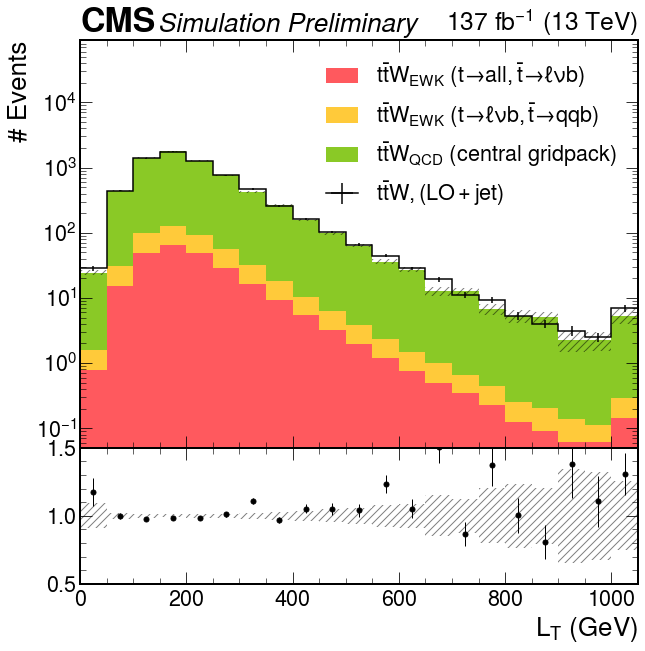

In [514]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.0}, sharex=True)

#f, ax = plt.subplots()

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='137',
    loc=0,
    ax=ax,
)


hep.histplot(
    [NLO_QED2_h_scaled.values(flow=True), NLO_QED1_h_scaled.values(flow=True), NLO_QCD_h_scaled.values(flow=True)],
    add_flow_to_edges(NLO_QCD_h.axes[0].edges),
    #density=True,
    histtype='fill',
    stack=True,
    label=[
        r'$t\bar{t}W_{EWK}\ (t \to all, \bar{t}\to\ell\nu b)$',
        r'$t\bar{t}W_{EWK}\ (t \to \ell\nu b,  \bar{t}\to q q b)$',
        r'$t\bar{t}W_{QCD}$ (central gridpack)',
    ],
    color=['#FF595E', '#FFCA3A', '#8AC926'],
    ax=ax,
)

hep.histplot(
    [LO_h_scaled.values(flow=True)],
    add_flow_to_edges(LO_h.axes[0].edges),
    yerr=[np.sqrt(LO_h_scaled.variances(flow=True))],
    #density=True,
    label=[r'$t\bar{t}W, (LO+jet)$'],#', up to O(\alpha_{S}^3\alpha_{EW}) and O(\alpha_{S}\alpha_{EW}^3)$'],
    color=['black'],
    ax=ax,
)

total = NLO_QED2_h_scaled.values(flow=True) + NLO_QED1_h_scaled.values(flow=True) + NLO_QCD_h_scaled.values(flow=True)
total_var = NLO_QED2_h_scaled.variances(flow=True) + NLO_QED1_h_scaled.variances(flow=True) + NLO_QCD_h_scaled.variances(flow=True)

add_uncertainty(
    total,
    np.sqrt(total_var),
    add_flow_to_edges(NLO_QCD_h.axes[0].edges),
    ax,
)

hep.histplot(
    [np.nan_to_num(LO_h_scaled.values(flow=True)/total, 0)],
    add_flow_to_edges(LO_h.axes[0].edges),
    yerr=[np.sqrt(LO_h_scaled.variances(flow=True))/total],
    histtype="errorbar",
    color='black',
    ax=rax,
)

add_uncertainty(
    np.ones_like(total),
    np.sqrt(total_var)/total,
    add_flow_to_edges(NLO_QCD_h.axes[0].edges),
    rax,
)

ax.set_ylabel(r'# Events')
rax.set_xlabel(r'$L_{T}\ (GeV)$')

ax.set_yscale("log")
ax.set_xlim(0, add_flow_to_edges(LO_h.axes[0].edges)[-1])
rax.set_ylim(0.5, 1.5)
ax.set_ylim(0.05, 9e4)

ax.legend(loc='upper right')

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/SMEFTatNLO/SM_comparison.pdf')

In [515]:
sum(LO_h_scaled.values())

6817.852083607938

In [263]:
NLO_QCD_h_scaled.variances()

array([  4.98015148,  95.23138545, 302.49215926, 384.40043849,
       278.98456319, 167.78786896,  99.26674935,  59.87391125,
        35.96598146,  21.53795417,  14.12377366,   8.72727511,
         5.58865874,   3.69908358,   2.61017586,   1.85754846,
         1.53728149,   1.05688102,   0.6245206 ,   0.52844051])

In [499]:
sum(total)

6823.201625144901

### BSM comparison

In [505]:
LO_bsm_h = output["ttlnuJet"]["lt"].copy()
NLO_QCD_bsm_h = output["TTWToLNu_SM"]["lt"].copy()
NLO_QED1_bsm_h = output["TTWToLNu_TtoLep_aTtoHad"]["lt"].copy()
NLO_QED2_bsm_h = output["TTWToLNu_TtoAll_aTtoLep"]["lt"].copy()

In [506]:
LO_bsm_h_scaled = LO_bsm_h*137*1000*xsecs["ttlnuJet"]/output["ttlnuJet"]["sumw"]
NLO_QCD_bsm_h_scaled = NLO_QCD_bsm_h*137*1000*xsecs["TTWToLNu_SM"]/output["TTWToLNu_SM"]["sumw"]
NLO_QED1_bsm_h_scaled = NLO_QED1_bsm_h*137*1000*xsecs["TTWToLNu_TtoLep_aTtoHad"]/output["TTWToLNu_TtoLep_aTtoHad"]["sumw"]
NLO_QED2_bsm_h_scaled = NLO_QED2_bsm_h*137*1000*xsecs["TTWToLNu_TtoAll_aTtoLep"]/output["TTWToLNu_TtoAll_aTtoLep"]["sumw"]

In [507]:
LO_bsm_h_scaled = LO_bsm_h_scaled * norm

In [511]:
norm

1.46045164009143

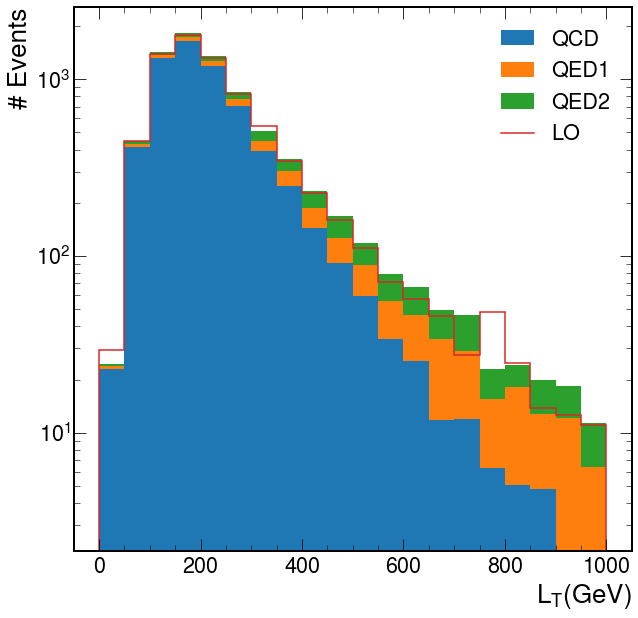

In [508]:
f, ax = plt.subplots()

hep.histplot(
    [NLO_QCD_h_scaled.values(), NLO_QED1_bsm_h_scaled.values(), NLO_QED2_bsm_h_scaled.values()],
    NLO_QCD_h.axes[0].edges,
    #density=True,
    histtype='fill',
    stack=True,
    label=['QCD', 'QED1', 'QED2']
)

hep.histplot(
    [LO_bsm_h_scaled.values()],
    LO_h.axes[0].edges,
    #density=True,
    label=['LO']
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")

plt.legend()

/tmp/ipykernel_1209434/2192187068.py:49: RuntimeWarning: invalid value encountered in true_divide
  [np.nan_to_num(LO_bsm_h_scaled.values(flow=True)/total, 0)],
/tmp/ipykernel_1209434/2192187068.py:51: RuntimeWarning: invalid value encountered in true_divide
  yerr=[np.sqrt(LO_bsm_h_scaled.variances(flow=True))/total],
/home/users/dspitzba/miniconda3/envs/workerenv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/users/dspitzba/miniconda3/envs/workerenv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/tmp/ipykernel_1209434/2192187068.py:59: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(total_var)/total,


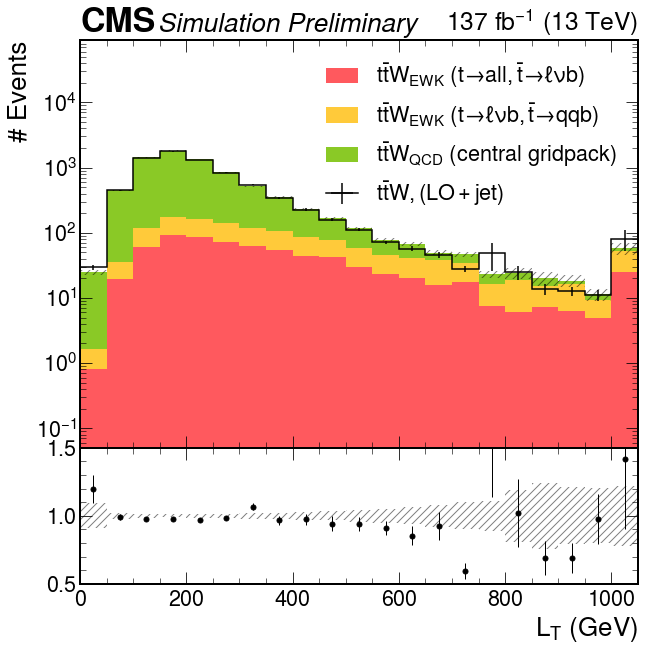

In [509]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.0}, sharex=True)

#f, ax = plt.subplots()

hep.cms.label(
    "Preliminary",
    data=False,
    lumi='137',
    loc=0,
    ax=ax,
)

hep.histplot(
    [NLO_QED2_bsm_h_scaled.values(flow=True), NLO_QED1_bsm_h_scaled.values(flow=True), NLO_QCD_h_scaled.values(flow=True)],
    add_flow_to_edges(NLO_QCD_h.axes[0].edges),
    #density=True,
    histtype='fill',
    stack=True,
    label=[
        r'$t\bar{t}W_{EWK}\ (t \to all, \bar{t}\to\ell\nu b)$',
        r'$t\bar{t}W_{EWK}\ (t \to \ell\nu b,  \bar{t}\to q q b)$',
        r'$t\bar{t}W_{QCD}$ (central gridpack)',
    ],
    color=['#FF595E', '#FFCA3A', '#8AC926'],
    ax=ax,
)

hep.histplot(
    [LO_bsm_h_scaled.values(flow=True)],
    add_flow_to_edges(LO_h.axes[0].edges),
    yerr=[np.sqrt(LO_bsm_h_scaled.variances(flow=True))],
    #density=True,
    label=[r'$t\bar{t}W, (LO+jet)$'],#', up to O(\alpha_{S}^3\alpha_{EW}) and O(\alpha_{S}\alpha_{EW}^3)$'],
    color=['black'],
    ax=ax,
)

total = NLO_QED2_bsm_h_scaled.values(flow=True) + NLO_QED1_bsm_h_scaled.values(flow=True) + NLO_QCD_h_scaled.values(flow=True)
total_var = NLO_QED2_bsm_h_scaled.variances(flow=True) + NLO_QED1_bsm_h_scaled.variances(flow=True) + NLO_QCD_h_scaled.variances(flow=True)

add_uncertainty(
    total,
    np.sqrt(total_var),
    add_flow_to_edges(NLO_QCD_h.axes[0].edges),
    ax,
)

hep.histplot(
    [np.nan_to_num(LO_bsm_h_scaled.values(flow=True)/total, 0)],
    add_flow_to_edges(LO_h.axes[0].edges),
    yerr=[np.sqrt(LO_bsm_h_scaled.variances(flow=True))/total],
    histtype="errorbar",
    color='black',
    ax=rax,
)

add_uncertainty(
    np.ones_like(total),
    np.sqrt(total_var)/total,
    add_flow_to_edges(NLO_QCD_h.axes[0].edges),
    rax,
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")
ax.set_xlim(0, add_flow_to_edges(LO_h.axes[0].edges)[-1])
rax.set_ylim(0.5, 1.5)

ax.legend()

ax.set_ylabel(r'# Events')
rax.set_xlabel(r'$L_{T}\ (GeV)$')

ax.set_yscale("log")
ax.set_xlim(0, add_flow_to_edges(LO_h.axes[0].edges)[-1])
rax.set_ylim(0.5, 1.5)
ax.set_ylim(0.05, 9e4)

ax.legend(loc='upper right')

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/SMEFTatNLO/BSM_comparison.pdf')

In [510]:
sum(total)

7711.249416319639

In [512]:
sum(LO_bsm_h_scaled.values())

7488.191186932835

In [513]:
sum(LO_sm_h_scaled.values())

NameError: name 'LO_sm_h_scaled' is not defined

In [56]:
sum(LO_h_scaled.values(flow=True))

2718.8198673042566

In [57]:
sum(NLO_QED1_bsm_h_scaled.values(flow=True))+sum(NLO_QED2_bsm_h_scaled.values(flow=True))

1248.8020505685408

In [58]:
sum(NLO_QED1_h_scaled.values(flow=True))+sum(NLO_QED2_h_scaled.values(flow=True))

188.35167605286998

In [59]:
sum(NLO_QED1_h_scaled.values(flow=True))+sum(NLO_QED2_h_scaled.values(flow=True))+sum(NLO_QCD_h_scaled.values(flow=True))

2719.102686553706

In [60]:
sum(NLO_QED1_bsm_h_scaled.values(flow=True))+sum(NLO_QED2_bsm_h_scaled.values(flow=True))+sum(NLO_QCD_h_scaled.values(flow=True))

3779.553061069377

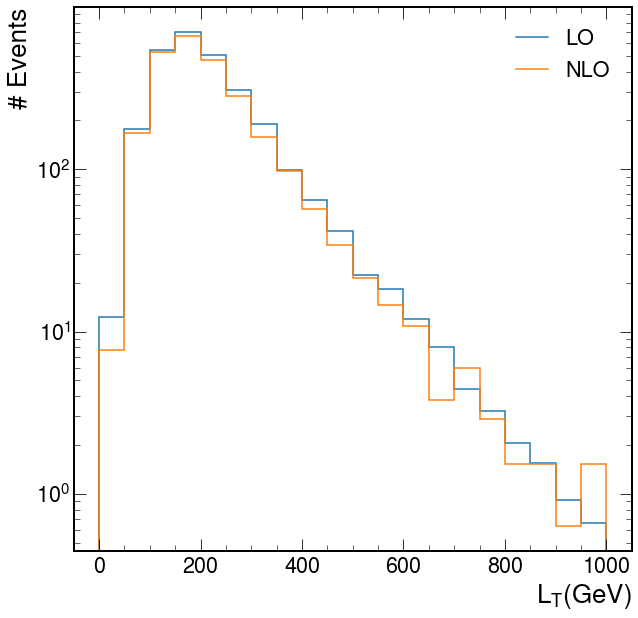

In [61]:
f, ax = plt.subplots()

hep.histplot(
    [LO_h_scaled.values(), NLO_QCD_h_scaled.values()],
    LO_h.axes[0].edges,
    #density=True,
    label=['LO', 'NLO']
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")

plt.legend()

## NanoGEN vs NanoAOD gen comparison

In [86]:
f_in = f'{base_dir}/TTWToLNu_SM_RunIISummer20_NanoGEN_NANO_v26/merged/merged_0.root'
TTW_NanoGEN = NanoEventsFactory.from_root(
    f_in,
    #'/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_60.root',
    schemaclass=NanoAODSchema,
).events()

In [90]:
met = TTW_NanoGEN.GenMET
lepton = TTW_NanoGEN.GenDressedLepton
jet = TTW_NanoGEN.GenJet

sel_jet = jet[((jet.pt>25)&(abs(jet.eta)<2.4))]

lt = met.pt + ak.sum(lepton.pt[:,:2], axis=1)

######

event_sel = ((ak.num(lepton)==2) & (abs(ak.sum(lepton.pdgId, axis=1))>0) & (ak.num(sel_jet)>3))

pt_axis = hist.axis.Regular(20, 0, 400, name="pt", label="pt", underflow=True, overflow=True)

ch_0 = hist.Hist(pt_axis)
ch_0.fill(pt=ak.max(lepton.pt, axis=1)[event_sel])


Hist(Regular(20, 0, 400, name='pt', label='pt'), storage=Double()) # Sum: 15388.0 (15468.0 with flow)

<Array [7.11, 39.9, 18.5, ... 43.7, 140, None] type='68178 * ?float32'>

In [91]:
TTW_NanoAOD = NanoEventsFactory.from_root(
    files_central_TTW[0],
    schemaclass=NanoAODSchema,
).events()

In [92]:
met = TTW_NanoAOD.GenMET
lepton = TTW_NanoAOD.GenDressedLepton
jet = TTW_NanoAOD.GenJet

sel_jet = jet[((jet.pt>25)&(abs(jet.eta)<2.4))]

lt = met.pt + ak.sum(lepton.pt[:,:2], axis=1)

######

event_sel = ((ak.num(lepton)==2) & (abs(ak.sum(lepton.pdgId, axis=1))>0) & (ak.num(sel_jet)>3))

ch_1 = hist.Hist(pt_axis)
ch_1.fill(pt=ak.max(lepton.pt, axis=1)[event_sel])


Hist(Regular(20, 0, 400, name='pt', label='pt'), storage=Double()) # Sum: 83003.0 (83572.0 with flow)

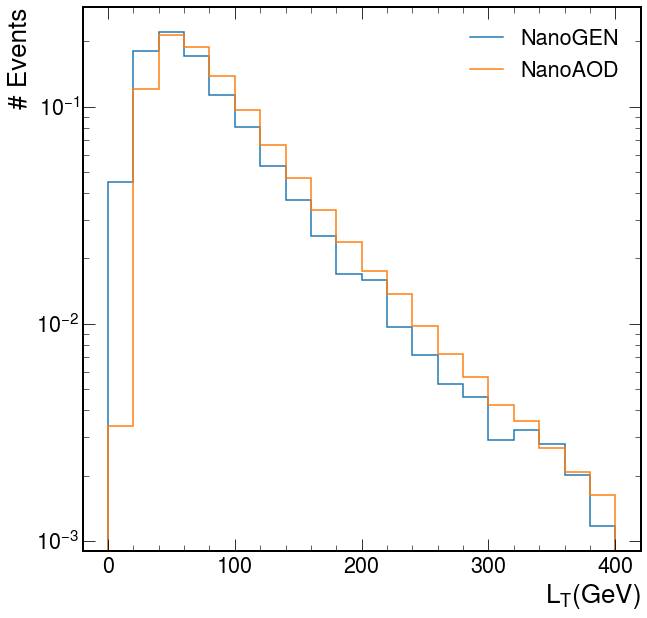

In [93]:
f, ax = plt.subplots()

hep.histplot(
    [ch_0.values(), ch_1.values()],
    ch_1.axes[0].edges,
    density=True,
    label=['NanoGEN', 'NanoAOD']
)

ax.set_ylabel(r'# Events')
ax.set_xlabel(r'$L_{T} (GeV)$')

ax.set_yscale("log")

plt.legend()

MET looks fine, both before and after basic event selection. LT is harder in NanoAOD. NanoAOD leptons are harder?

## Other stuff

In [43]:
mapping = {
    "LO": [
        "ttlnuJet",
    ],
    "NLO":[
        "TTWToLNu_SM",
        "TTWToLNu_TtoAll_aTtoLep",
        "TTWToLNu_TtoLep_aTtoHad"
    ],
}

In [52]:
lt_axis = hist.axis.Regular(20, 0, 1000, name="lt", label="$L_{T}$ (GeV)")

In [55]:
RebinHist(output["ttlnuJet"]["lt"], lt=lt_axis)

ValueError: bins > 0 required

In [50]:
# Taken from Yi-Mu: https://gist.github.com/yimuchen/a5e200c001ef4ea01681a7dd8fe89162#file-integrate_and_rebin-py-L158
def RebinHist(h, **kwargs):
    """
    Rebinning a scikit-hist histogram. 2 types of values can be accepted as the
    argument values:
    - Derivatives of the `hist.rebin` argument. In this case we directly use the
    UHI facilities to perform the rebinning.
    - A new axis object where all the bin edges lands on the old bin edges of the
    given histogram. In this case a custom intergration loop is performed to
    extract the rebinning. Beware that this methods is very slow, as it requires
    a loop generation of all possible UHI values after the rebinning, so be sure
    that rebinning is performed as the final step of the histogram reduction. See
    `_rebin_single_scikit` for more information regarding this method.
    """
    h = h.copy()
    for var, var_val in kwargs.items():
        if isinstance(var_val, hist.rebin):
            h = h[{var: var_val}]
        else:
            h = _rebin_single_scikit(h, var, var_val)
    return h


def __check_scikit_axis_compat(axis1, axis2):
    """
    Checking that axis 2 is rebin-compatible with axis 1. This checks that:
    1. The two histogram share the same name.
    2. The edges of the second axis all land on the edges of the first axis.
    If the two axis are compatible the function will return an array of the bin
    index of the axis 1 that the bin edges of axis 2 falls on.
    """
    assert axis1.name == axis2.name, \
    'Naming of the axis is required to match'
    # Getting the new bin edges index for the old bin edges
    try:
        return [
        np.argwhere(axis1.edges == new_edge)[0][0] for new_edge in axis2.edges
        ]
    except IndexError as err:
        raise ValueError(f"Bin edges of the axis {axis2} is incompatible with {axis1}")


def _get_all_indices(axis):
    """
    Getting all possible (integer) bin index values given a scikit-hep histogram.
    The special indices of hist.underflow and hist.overflow will be included if the
    axis in questions has those traits.
    """
    idxs = list(range(len(axis)))
    if axis.traits.underflow:  # Extension to include the under/overflow bins
        idxs.insert(0, hist.underflow)
        if axis.traits.overflow:
            idxs.append(hist.overflow)
    return idxs


def _rebin_single_scikit(h, old_axis, new_axis):
    """
    Rebinning a single axis of a scikit-hist histogram. This includes the following
    routines:
    - Generating a new scikit hep instance that perserves axis ordering with the
    exception of the rebinned axis (in place) replacement.
    - Setting up the integration ranges required to calculate the bin values of the
    new histogram.
    - Looping over the UHI values of the new histogram and performing the a
    summation over the specified range on the old histogram to fill in the new
    values.
    As here we have variable number of axis each with variable number of bins, this
    method will require the use of more old fashioned python looping, which can be
    very slow for large dimensional histograms with many bins for each axis. So be
    sure to make rebinning be the final step in histogram reduction.
    """

    #assert isinstance(h, hist.NamedHist), "Can only process named histograms"

    # Additional type casing
    if type(old_axis) == str:
        return _rebin_single_scikit(h, h.axes[old_axis], new_axis)
    axis_name = old_axis.name

    ## Creating the new histogram instance with identical axis ordering.
    all_axes = list(h.axes)
    all_axes[all_axes.index(old_axis)] = new_axis
    h_rebinned = hist.NamedHist(*all_axes, storage=h._storage_type())

    # Getting the all possible bin indices for all axes in the old histogram
    bin_idx_dict = {ax.name: _get_all_indices(ax) for ax in h.axes}

    # Getting the new bin edges index for the old bin edges
    new_bin_edge_idx = __check_scikit_axis_compat(old_axis, new_axis)
    if new_axis.traits.underflow:  # Adding additional underflow/overflow
        new_bin_edge_idx.insert(0, bin_idx_dict[axis_name][0])
        if new_axis.traits.overflow:
            new_bin_edge_idx.append(bin_idx_dict[axis_name][-1])

    # Generating a the int range pair. Additional parsing will be required for the
    # under/overflow bins

    def make_slice(index):

        start = new_bin_edge_idx[index]
        stop = new_bin_edge_idx[index + 1]
        if start == hist.underflow:
            start = -1
        if stop == hist.overflow:
            stop = len(old_axis)
        return slice(int(start), int(stop))

    new_axis_idx = _get_all_indices(new_axis)
    new_int_slice = [make_slice(i) for i in range(len(new_axis_idx))]
    assert len(new_axis_idx) == len(new_bin_edge_idx) - 1

    new_idx_dict = bin_idx_dict.copy()
    new_idx_dict[axis_name] = new_axis_idx
    bin_idx_dict[axis_name] = new_int_slice

    name_list = list(bin_idx_dict.keys())
    new_idx = [x for x in itertools.product(*[x for x in new_idx_dict.values()])]
    old_int = [x for x in itertools.product(*[x for x in bin_idx_dict.values()])]

    for o, n in zip(old_int, new_idx):
        n_uhi = {name: n[name_idx] for name_idx, name in enumerate(name_list)}
        o_uhi = {name: o[name_idx] for name_idx, name in enumerate(name_list)}
        # Single variable histogram, with just the axis of interest
        h_rebinned[n_uhi] = integrate_hist_scikit(h, **o_uhi)

    return h_rebinned

def integrate_hist_scikit(h, **kwargs):
    """
    Given a scikit-hist histogram object return a reduced histogram with specified
    axes integrated out.
    For scikit-hist histograms, the integration should be formed in 3 steps:
    - slicing the histogram to contain only the range of interest
    - Setting overflow values to 0 (excluding the values from future calculations)
    - Summing over the axes of interest.
    The latter 2 steps will only be carried out if the var_slice doesn't uniquely
    identify a singular bin in the histogram axis
    """
    # Reduction in parallel.
    r = h[kwargs]
    for var, var_slice in kwargs.items():
        # In the case that histogram has been reduced to singular value simple return
        #if not isinstance(r, hist.NamedHist):
        #    return r
        if var in [x.name for x in r.axes]:
            ax = h.axes[var]
            
            get_underflow = var_slice.start == None or var_slice.start == -1
            get_overflow = var_slice.stop == None or var_slice.stop == len(ax)
            if not get_underflow and ax.traits.underflow:
                r[{var: hist.underflow}] = np.zeros_like(r[{var: hist.underflow}])
            if not get_overflow and ax.traits.overflow:
                r[{var: hist.overflow}] = np.zeros_like(r[{var: hist.overflow}])
                
            # Sum over all remaining elements on axis
            r = r[{var: sum}]
    return r
